In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:03<00:00, 7970908.42it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 1127262.88it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5942573.69it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15141849.22it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



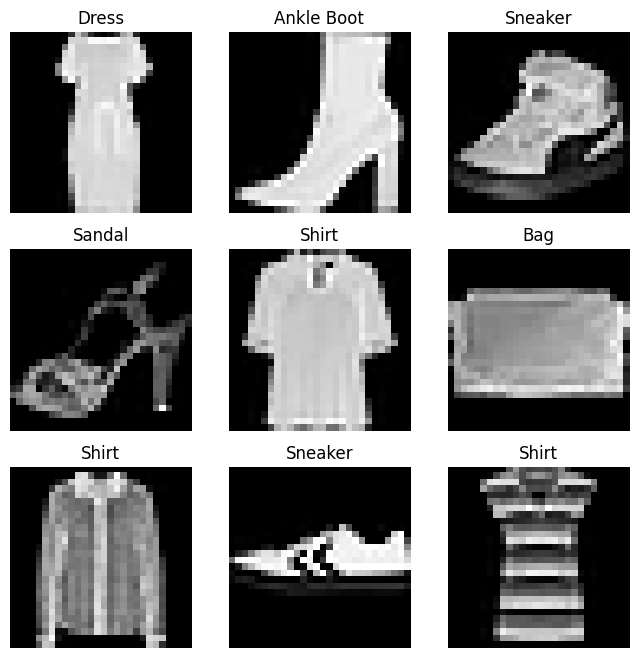

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) <built-in method type of Tensor object at 0x107e2b430>


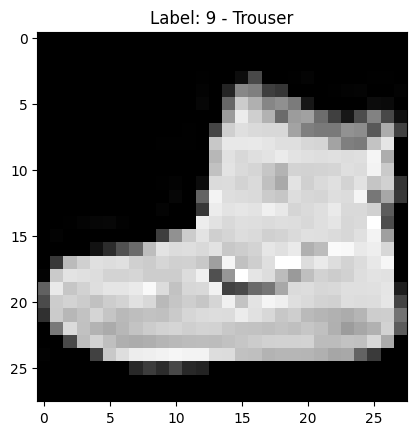

Labels batch shape: torch.Size([64])


In [6]:
batch_size = 64

train_dl = DataLoader(training_data, batch_size=batch_size)
test_dl = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dl:
    train_features, train_labels = next(iter(train_dl))
    print(f'Shape of X [N, C, H, W]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.type}')
    image = train_features[0].squeeze()
    label = train_labels[0]
    sample_idx= torch.randint((label), size = (1,)).item()
    plt.title(f"Label: {label} - {labels_map[sample_idx]}")
    plt.imshow(image, cmap="gray")
    plt.show()
    print(f"Labels batch shape: {train_labels.size()}")
    break

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [12]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [13]:
device = 'cpu'
model = Model().to(device)
print(model.parameters)

<bound method Module.parameters of Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)>


In [15]:
learning_rate = 1e-3
epochs = 5

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
# Training
def trainloop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [17]:
# Evaluation
def evaluate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

In [19]:
for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    trainloop(train_dl, model, loss_fn, optimizer)
    evaluate(test_dl, model, loss_fn)
print("Done.")

Epoch 1
-------------------------------
loss: 1.151363 [    0/60000]
loss: 1.154874 [ 6400/60000]
loss: 0.973892 [12800/60000]
loss: 1.119091 [19200/60000]
loss: 0.990162 [25600/60000]
loss: 1.017034 [32000/60000]
loss: 1.060578 [38400/60000]
loss: 0.982976 [44800/60000]
loss: 1.035525 [51200/60000]
loss: 0.975362 [57600/60000]
Test Error: 
 Accuracy: 66.1%, Avg loss: 0.980506

Epoch 2
-------------------------------
loss: 1.034304 [    0/60000]
loss: 1.057147 [ 6400/60000]
loss: 0.861876 [12800/60000]
loss: 1.027557 [19200/60000]
loss: 0.901323 [25600/60000]
loss: 0.924179 [32000/60000]
loss: 0.983271 [38400/60000]
loss: 0.909006 [44800/60000]
loss: 0.958403 [51200/60000]
loss: 0.909081 [57600/60000]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.908727

Epoch 3
-------------------------------
loss: 0.948697 [    0/60000]
loss: 0.989255 [ 6400/60000]
loss: 0.781406 [12800/60000]
loss: 0.962678 [19200/60000]
loss: 0.841476 [25600/60000]
loss: 0.856666 [32000/60000]
loss: 0.928611 [38400/60

In [50]:
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    pred_y = torch.randint((pred[0].argmax(0)), size = (1,)).item()
    y = torch.randint(y, size=(1,)).item()
    predicted, actual = labels_map[pred_y], labels_map[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Shirt", Actual: "Shirt"
